In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
import pcmdpy_gpu as ppy
import seaborn as sns
from astropy.visualization import make_lupton_rgb
from matplotlib import animation, rc
from tqdm import tqdm
from IPython.display import HTML, Image
%matplotlib inline

/n/home01/bcook/.conda/envs/py36/lib/python3.6/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/n/home01/bcook/.conda/envs/py36/lib/python3.6/site-packages/pysynphot/locations.py:329: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [2]:
plt.style.use('easy-dark')

In [3]:
f = ppy.instrument.default_m31_filters(10000., 10000.)
iso_model = ppy.isochrones.Isochrone_Model(f)
driv = ppy.driver.Driver(iso_model, max_Nim=2048, gpu=True)

Please wait while the GPU states are initialized

In [4]:
figdir = 'figures/'

In [5]:
g = ppy.galaxy.CustomGalaxy(
    ppy.metalmodels.SingleFeH(),
    ppy.dustmodels.SingleDust(),
    ppy.sfhmodels.TauModel(),
    ppy.distancemodels.VariableDistance()
)
g.set_params([0., -2., 0., 5.0, 25.])

In [6]:
def make_image(logNpix, ax=None, label=True, Nim_1=2048, w=0.5, Q=8, stretch=1.):
    g.set_params([0., -2., logNpix, 5.0, 25.])
    Npix = 10.**(logNpix)
    D = 1.0 * np.sqrt(Npix  / 10.)
    Nim = int((Nim_1) * (10. / Npix)**.5)
    Nim = max(Nim, 4)
    Nim_sim = 2**(int(np.ceil(np.log10(Nim)/np.log10(2.))))
    Nim_sim = max(Nim_sim, 128)
    _, im = driv.simulate(g, Nim_sim, dither=False)
    im0 = im[0][:Nim, :Nim] / im[0].mean()
    im1 = im[1][:Nim, :Nim] / im[1].mean()
    image = make_lupton_rgb(im0, w*im0 + (1. - w)*im1, im1, Q=Q, stretch=stretch)
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))
        fig.tight_layout()
#         ax.axis('off')
    ax.imshow(image, aspect='auto')
    ax.grid(color='w', linestyle='-', lw=np.round(3. / Nim, 2))
#     plt.rcParams["axes.edgecolor"] = "0.15"
#     plt.rcParams["axes.linewidth"]  = 1.25
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        left=False,
        right=False,
        labelbottom=False) 
    ax.set_xticks(np.arange(Nim+1)-0.5)
    ax.set_xticklabels([])
    ax.set_yticks(np.arange(Nim+1)-0.5)
    ax.set_yticklabels([])
    if label:
        if logNpix <= 2.:
            npt = f'{10.**logNpix:.0f}'
        else:
            npt = f'{logNpix:.0f}'
            npt = r'$10^{' + npt + r'}$'
        if D >= 1000:
            dt = f'\nD = {D/1000:.0f} Gpc'
        else:
            dt = f'\nD = {D:.0f} Mpc'
        t = r'$\mathrm{N_{pix}}$ = ' + npt + dt
        ax.text(0.05, .95, t, verticalalignment='top',
                horizontalalignment='left', transform=ax.transAxes, fontsize=18, bbox={'facecolor':'k', 'alpha':0.3})
    return fig, ax

# Npix

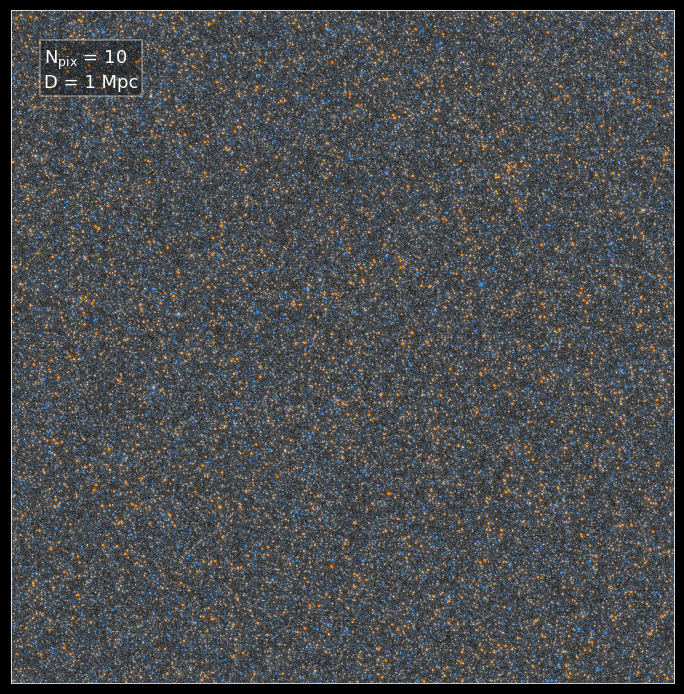

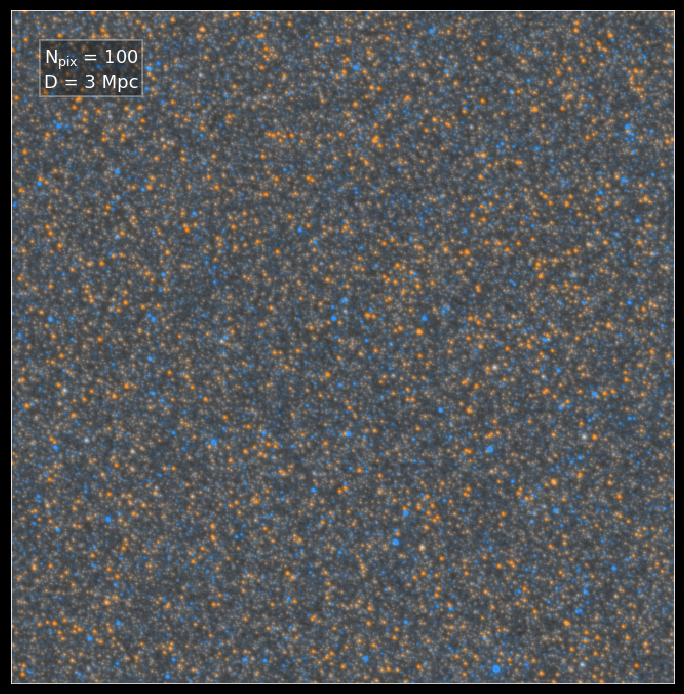

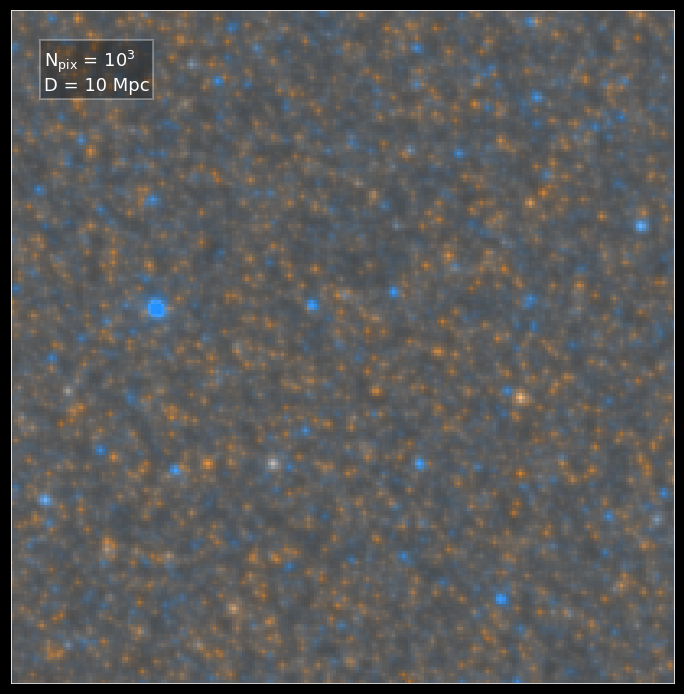

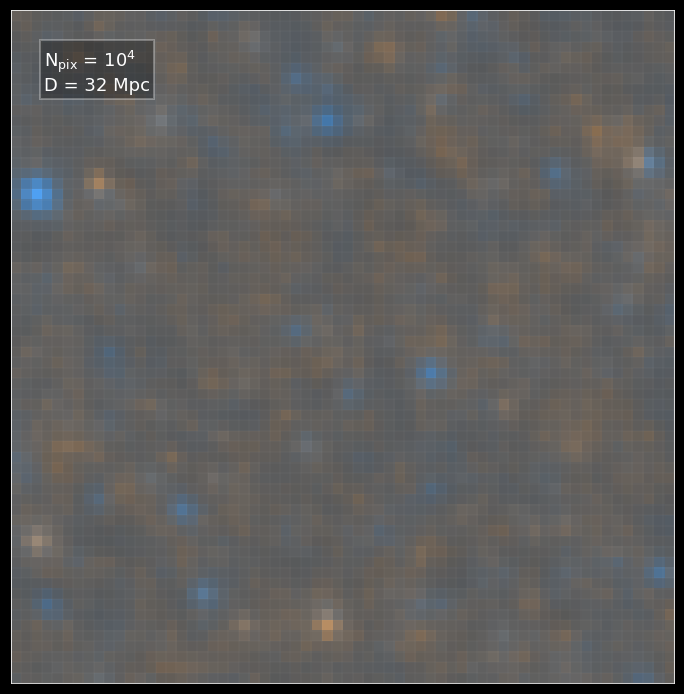

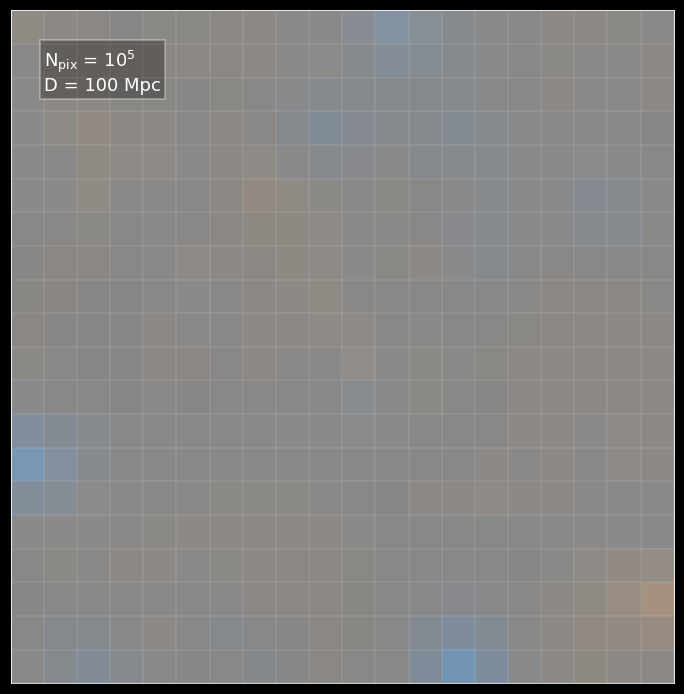

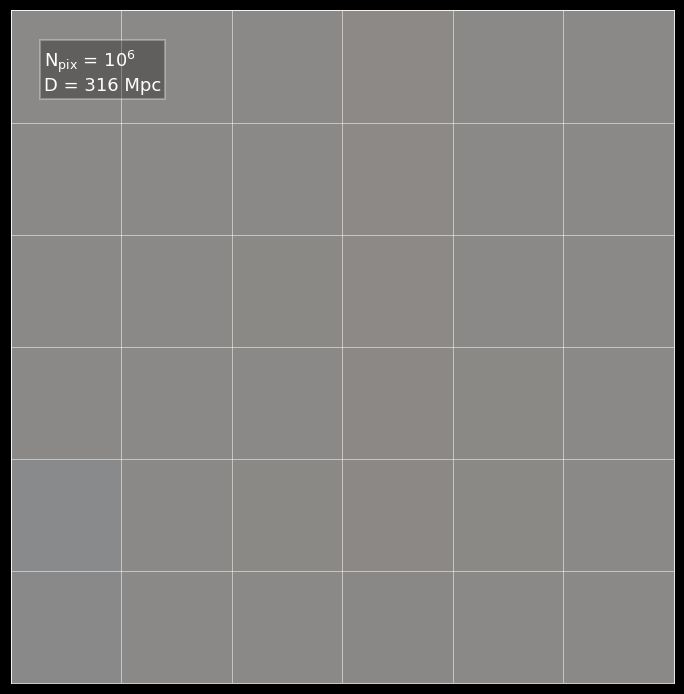

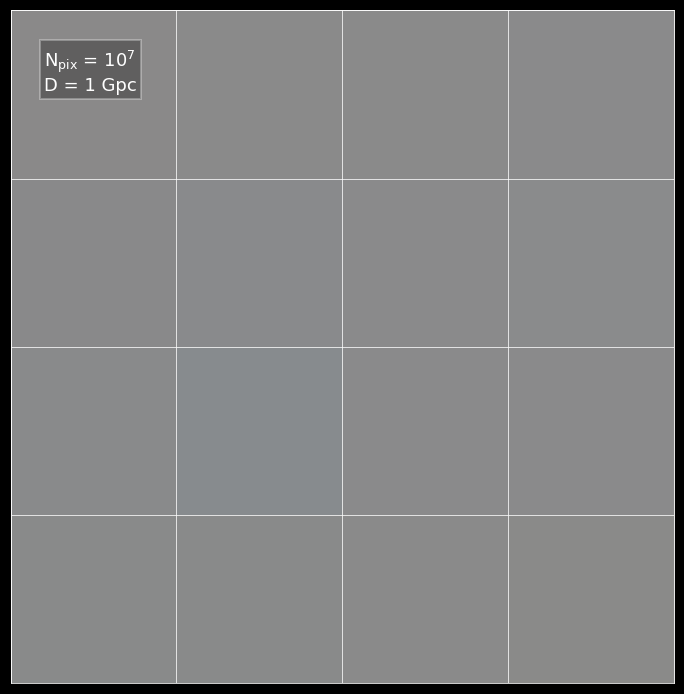

In [91]:
for Npix in [1., 2., 3., 4., 5., 6., 7.]:
    fig, ax = make_image(Npix, stretch=(1.0 if Npix <= 4. else 0.3))
    fig.savefig(figdir + f'NpixIms_{Npix:.0f}.png', dpi=300)

# Example pCMD (Npix = 2.)

In [107]:
g.set_params([0., -2., 3., 5., 25.])
Nim = 256
pcmd, im = driv.simulate(g, Nim, dither=True, shot_noise=False)

In [108]:
w, Q, stretch = .5, 8, 1.
im0 = im[0][:Nim, :Nim] / im[0].mean()
im1 = im[1][:Nim, :Nim] / im[1].mean()
image = make_lupton_rgb(im0, w*im0 + (1. - w)*im1, im1, Q=Q, stretch=stretch)

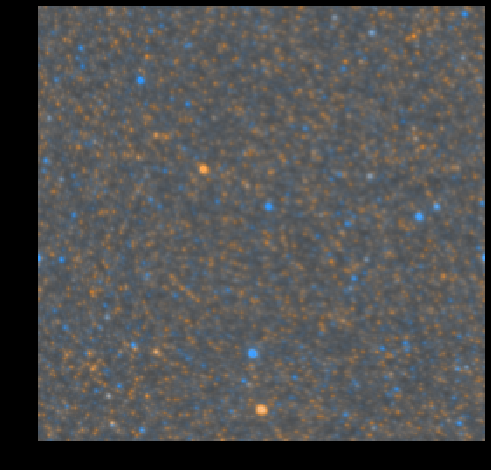

In [112]:
fig, ax = plt.subplots(figsize=(8,8))
ax.axis('off')
ax.imshow(image)
fig.savefig(figdir + 'pcmd_im.jpg')

CPU times: user 1.13 s, sys: 25.8 ms, total: 1.16 s
Wall time: 1.26 s


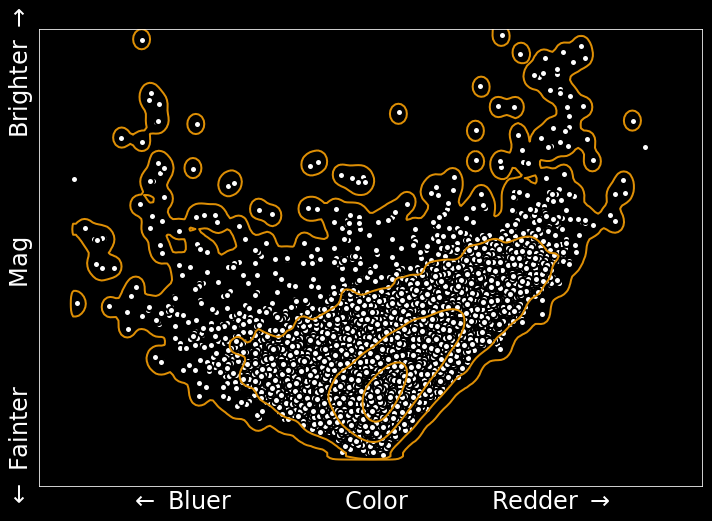

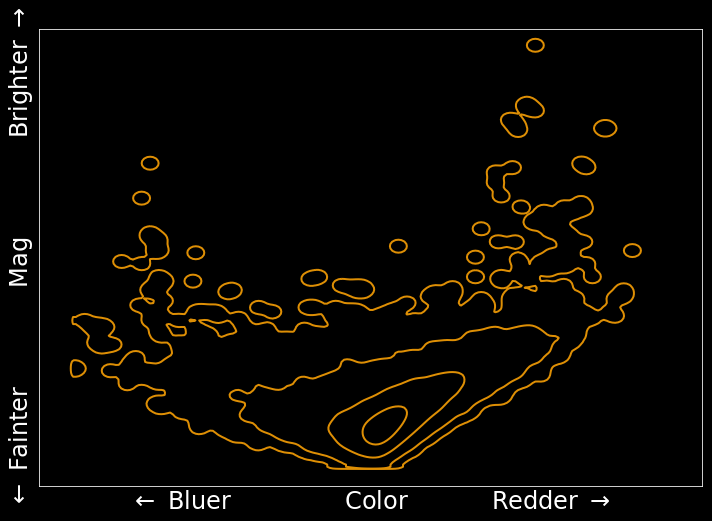

In [120]:
%%time
fig, ax = plt.subplots(figsize=(10, 7))
fig.tight_layout()
# ppy.plotting.plot_pcmd_contours(pcmd, ax=ax, sig_levels=[1., 2., 3., 4.], color='k')
# ppy.plotting.plot_isochrone(iso_model, axes=ax, alpha=0.)
fs = 24
ax.set_xlabel(r'$\leftarrow$ ' + 'Bluer \t\t Color \t\t Redder' + r' $\rightarrow$', fontsize=fs)
ax.set_ylabel(r'$\leftarrow$ ' + 'Fainter \t\t Mag \t\t Brighter' + r' $\rightarrow$', fontsize=fs)
ax.set_xticks([]), ax.set_yticks([])
ax.set_xlim([-0.5, 3.5])
ax.set_ylim([25.3, 21.5])
ax.autoscale(False)
fig.savefig(figdir + 'pcmd_Npix2_1.pdf')

plt.plot(pcmd[1], pcmd[0], 'wo', mec='k', ms=7, zorder=-10)
ax.set_xlim([-0.5, 3.5])
ax.set_ylim([25.3, 21.5])
fig.savefig(figdir + 'pcmd_Npix2_2.jpg')

color = sns.color_palette('colorblind')[1]

ppy.plotting.plot_pcmd_contours(pcmd, ax=ax, sig_levels=[1.,2., 3., 4.], keep_limits=True, color=color)
ax.set_xlim([-0.5, 3.5])
ax.set_ylim([25.3, 21.5])
fig.savefig(figdir + 'pcmd_Npix2_3.jpg')

fig, ax = plt.subplots(figsize=(10, 7))
fig.tight_layout()
# ppy.plotting.plot_pcmd_contours(pcmd, ax=ax, sig_levels=[1., 2., 3., 4.], color='k')
# ppy.plotting.plot_isochrone(iso_model, axes=ax, alpha=0.)
fs = 24
ax.set_xlabel(r'$\leftarrow$ ' + 'Bluer \t\t Color \t\t Redder' + r' $\rightarrow$', fontsize=fs)
ax.set_ylabel(r'$\leftarrow$ ' + 'Fainter \t\t Mag \t\t Brighter' + r' $\rightarrow$', fontsize=fs)
ax.set_xticks([]), ax.set_yticks([])
ax.set_xlim([-0.5, 3.5])
ax.set_ylim([25.3, 21.5])
ax.autoscale(False)
ppy.plotting.plot_pcmd_contours(pcmd, ax=ax, sig_levels=[1.,2., 3., 4.], keep_limits=True, color=color)
fig.savefig(figdir + 'pcmd_Npix2_4.pdf')

In [121]:
! git add . && git commit -m "blah" && git push origin master

[master 4c438c1] blah
 3 files changed, 21 insertions(+), 15 deletions(-)
 rewrite Thesis_Defense/figures/pcmd_Npix2_4.pdf (74%)
Counting objects: 13, done.
Delta compression using up to 48 threads.
Compressing objects: 100% (7/7), done.
Writing objects: 100% (7/7), 129.75 KiB | 0 bytes/s, done.
Total 7 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
To git@github.com:bacook17/pixcmd.git
   bed1057..4c438c1  master -> master


In [128]:
g.set_params([0., -2., 2., 2., 25.])
pcmd, _ = driv.simulate(g, 1024, dither=False)

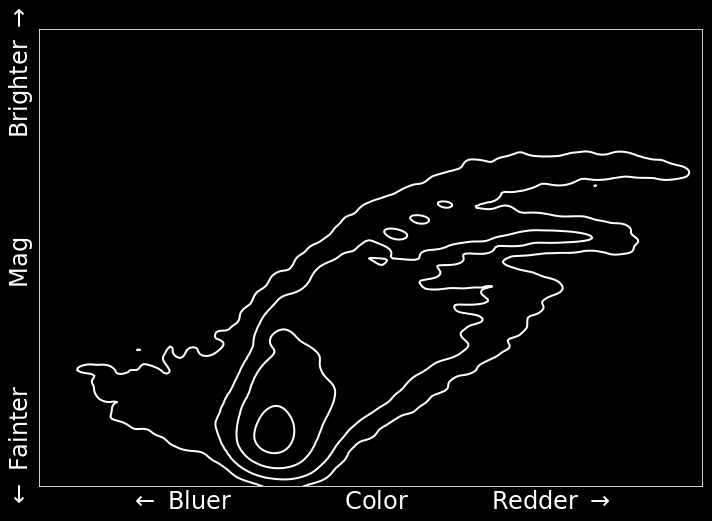

In [130]:
fig, ax = plt.subplots(figsize=(10, 7))
fig.tight_layout()
ppy.plotting.plot_pcmd_contours(pcmd, ax=ax, sig_levels=[1., 2., 3., 4.], color='w')
ppy.plotting.plot_isochrone(iso_model, axes=ax, alpha=0.)
fs = 24
ax.set_xlabel(r'$\leftarrow$ ' + 'Bluer \t\t Color \t\t Redder' + r' $\rightarrow$', fontsize=fs)
ax.set_ylabel(r'$\leftarrow$ ' + 'Fainter \t\t Mag \t\t Brighter' + r' $\rightarrow$', fontsize=fs)
ax.set_xticks([]), ax.set_yticks([])
ax.set_ylim([28.4, 22.])
ax.autoscale(False)
fig.savefig(figdir + 'pcmd_Npix2_old.pdf')

# Simplified Flowchart

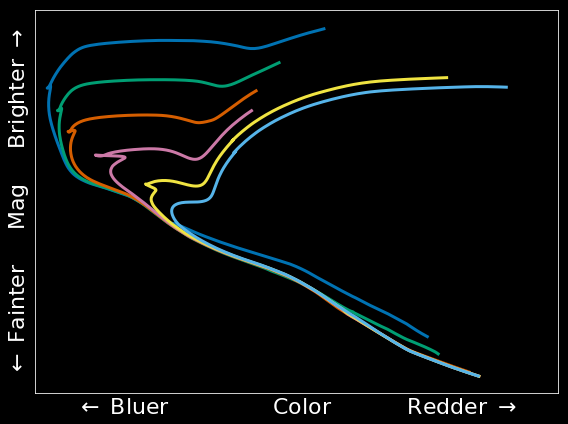

In [145]:
fig, ax = plt.subplots(figsize=(8,6))
fig.tight_layout()
fs = 22
ax.set_xlabel(r'$\leftarrow$ ' + 'Bluer \t\t Color \t\t Redder' + r' $\rightarrow$', fontsize=fs)
ax.set_ylabel(r'$\leftarrow$ ' + 'Fainter \t Mag \t Brighter' + r' $\rightarrow$', fontsize=fs)
ax.set_xticks([]), ax.set_yticks([])
ax.autoscale(False)
fig.tight_layout()
for a in np.arange(7.5, 10.2, 0.5):
    y = iso_model.MIST_df['ACS_WFC_F814W'].values
    x = iso_model.MIST_df['ACS_WFC_F475W'].values - iso_model.MIST_df['ACS_WFC_F814W'].values
    mask = np.isclose(iso_model.MIST_df.age, a)&np.isclose(iso_model.MIST_df['[Fe/H]_init'], 0.0)&(iso_model.MIST_df.EEP <= 605)
    ax.plot(x[mask], y[mask], lw=3)
ax.set_xlim([-.5, 5.5])
ax.set_ylim([13., -7.])
plt.savefig(figdir + 'isochrones_many.pdf')

# GIFs

In [271]:
def get_pcmd_ax(xlim=[-1.5,3.5], ylim=[35,20]):
    fig, ax = plt.subplots(figsize=(8,6))
    fig.tight_layout()
    fs = 22
    ax.set_xlabel(r'$\leftarrow$ ' + 'Bluer \t\t Color \t\t Redder' + r' $\rightarrow$', fontsize=fs)
    ax.set_ylabel(r'$\leftarrow$ ' + 'Fainter \t Mag \t Brighter' + r' $\rightarrow$', fontsize=fs)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xticks([]), ax.set_yticks([])
    ax.autoscale(False)
    return fig, ax

In [272]:
def plot_feh(logfeh, Nim=1024, xlim=[-1.5,3.5], ylim=[35,20]):
    fig, ax = get_pcmd_ax(xlim=xlim, ylim=ylim)
    g.set_params([logfeh, -2., 3.0, 3.0, 30.])
    pcmd, _ = driv.simulate(g, Nim, dither=False, shot_noise=False)
    ppy.plotting.plot_pcmd_contours(pcmd, ax=ax, label=f'Metallicity = {logfeh:.1f}', keep_limits=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(loc=2)
    return fig, ax

In [273]:
def plot_tau(tau, Nim=1024, xlim=[-1.5,3.5], ylim=[35,20]):
    fig, ax = get_pcmd_ax(xlim=xlim, ylim=ylim)
    g.set_params([0., -2., 3.0, tau, 30.])
    pcmd, _ = driv.simulate(g, Nim, dither=False, shot_noise=False)
    ppy.plotting.plot_pcmd_contours(pcmd, ax=ax, label=r'$\tau$ = '+f'{tau:.1f} Gyr', keep_limits=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(loc=2)
    return fig, ax

In [274]:
def plot_Npix(logNpix, Nim=1024, xlim=[-1.5,3.5], ylim=[35,20]):
    fig, ax = get_pcmd_ax(xlim=xlim, ylim=ylim)
    g.set_params([0., -2., logNpix, 3.0, 30.])
    pcmd, _ = driv.simulate(g, Nim, dither=False, shot_noise=False)
    ppy.plotting.plot_pcmd_contours(pcmd, ax=ax, label=r'$\log\,\mathrm{N_{pix}}$ = '+f'{logNpix:.1f}', keep_limits=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(loc=2)
    return fig, ax

In [275]:
def plot_dmod(dmod, Nim=1024, xlim=[-1.5,3.5], ylim=[35,20]):
    fig, ax = get_pcmd_ax(xlim=xlim, ylim=ylim)
    g.set_params([0., -2., 3.0, 3.0, dmod])
    pcmd, _ = driv.simulate(g, Nim, dither=False, shot_noise=False)
    Dmpc = ppy.distancemodels.dmod_to_mpc(dmod)
    ppy.plotting.plot_pcmd_contours(pcmd, ax=ax, label=f'D = {Dmpc:.1f} Mpc', keep_limits=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(loc=2)
    return fig, ax

In [276]:
def plot_Npix_dmodfixed(logNpix, Nim=1024, dmod_np2=30., xlim=[-1.5,3.5], ylim=[35,20]):
    dnp = logNpix - 2.0
    dmod = dmod_np2 + 2.5*(dnp)
    fig, ax = get_pcmd_ax(xlim=xlim, ylim=ylim)
    g.set_params([0., -2., logNpix, 3.0, dmod])
    pcmd, _ = driv.simulate(g, Nim, dither=False, shot_noise=False)
    Dmpc = ppy.distancemodels.dmod_to_mpc(dmod)
    ppy.plotting.plot_pcmd_contours(pcmd, ax=ax, label=r'$\log\,\mathrm{N_{pix}}$ = '+f'{logNpix:.1f}', keep_limits=True)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(loc=2)
    return fig, ax

In [277]:
Npixs = np.arange(1.0, 6.1, 0.2)
for i, lnp in tqdm(enumerate(Npixs), total=len(Npixs)):
    fig, ax = plot_Npix(lnp, Nim=1024, xlim=[-1.5, 3.5], ylim=[37, 19])
    fig.savefig(figdir + f'pcmds/Npix_{i:02d}.png')
    plt.close(fig)
    
    dmod = 30. - 2.5*(lnp - 3.0)
    fig, ax = plot_dmod(dmod)
    fig.savefig(figdir + f'pcmds/dmod_{i:02d}.png')
    plt.close(fig)

100%|██████████| 26/26 [01:49<00:00,  4.17s/it]


In [278]:
fehs = np.arange(-2.0, 0.5, 0.1)
for i, feh in tqdm(enumerate(fehs), total=len(fehs)):
    fig, ax = plot_feh(feh, Nim=1024, xlim=[-0.5, 3.5], ylim=[31,26])
    fig.savefig(figdir + f'pcmds/feh_{i:02d}.png')
    plt.close(fig)

100%|██████████| 25/25 [00:54<00:00,  2.22s/it]


In [279]:
taus = np.arange(0.2, 6.1, 0.2)
for i, tau in tqdm(enumerate(taus), total=len(taus)):
    fig, ax = plot_tau(tau, Nim=1024, xlim=[-1.0, 3.5], ylim=[31,24])
    fig.savefig(figdir + f'pcmds/tau_{i:02d}.png')
    plt.close(fig)

100%|██████████| 30/30 [01:01<00:00,  2.08s/it]
